# Finns and Alcohol Consumption: Do Seasonal Changes in Weather Affect Our Drinking Habits? 
### Sini Suihkonen, Outi Savolainen and Fanni Franssila

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

In [4]:
print("We are so good!")

We are so good!


In [5]:
def load_xls(file_name:str, year: int):
    dataframes = []
    months = ["Tammi", "Helmi", "Maalis", "Huhti", "Touko", "Kesä", "Heinä", "Elo", "Syys", "Loka", "Marras", "Joulu"]
    months_eng = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    xls = pd.ExcelFile(file_name)
    for (i, month) in enumerate(months):
        name_of_sheet = f"{month}kuu {year}"
        df = pd.read_excel(xls, name_of_sheet,skiprows=[0,1,2], usecols=("I"))
        # Add month column to the dataframe. For example "Tammikuu2020".
        df[f"{months_eng[i]}{year}"] = pd.concat([df.iloc[3:4], df.iloc[14:15], df.iloc[21:22], df.iloc[34:35]])
        # Drop rows with NaNs. After this we have only four rows containing total consumption for all types of alchohol.
        df = df.dropna()
        # Remove the first useless row of the dataframe.
        df = df.iloc[:, 1:]
        # Change index names
        df = df.rename(index={3:"Beer", 14:"Wine", 21:"Strong Wine", 34:"Spririts"})
        dataframes.append(df)
    total = pd.concat(dataframes, axis=1)
    
    return total

alc_data2020 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2020.xlsx", 2020)
alc_data2019 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2019.xlsx", 2019)
alc_data2018 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2018.xlsx", 2018)
alc_data2017 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2017.xlsx", 2017)

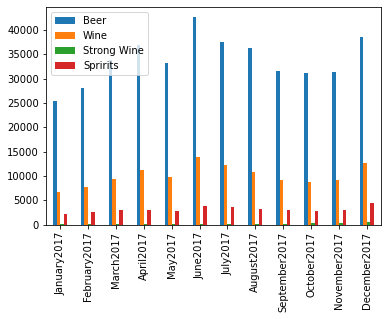

In [55]:
# Plotting alcohol data
data_for_plotting = alc_data2017.T.astype(int)
ax = data_for_plotting.plot.bar()
ax.xaxis.set_major_formatter(plt.FixedFormatter(data_for_plotting.index.to_series()))
plt.show()


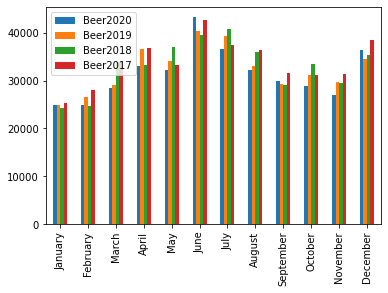

In [18]:
# Better plotting
adata2017 = alc_data2017.T.astype(int)
adata2018 = alc_data2018.T.astype(int)
adata2019 = alc_data2019.T.astype(int)
adata2020 = alc_data2020.T.astype(int)


yearly_beer = pd.DataFrame(index=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], columns=["Beer2020", "Beer2019", "Beer2018", "Beer2017"])
yearly_beer["Beer2020"] = adata2020["Beer"].values
yearly_beer["Beer2019"] = adata2019["Beer"].values
yearly_beer["Beer2018"] = adata2018["Beer"].values
yearly_beer["Beer2017"] = adata2017["Beer"].values
yearly_beer

ax = yearly_beer.plot.bar()
ax.xaxis.set_major_formatter(plt.FixedFormatter(yearly_beer.index.to_series()))
plt.show()

In [26]:
# WEATHER DATA
def load_csv(file_name:str):
    df_weather = pd.read_csv(file_name)

    # replace negative snow depth values
    df_weather["Lumensyvyys (cm)"].replace({-1: 0}, inplace=True)

    # Translate relevant column names into English
    df_weather = df_weather.rename(columns={"Kk": "Month", "Pilvien määrä (1/8)": "Cloud cover (1/8)", "Ilmanpaine (msl) (hPa)": "Air pressure(msl) (hPa)",
                                        "Sademäärä (mm)": "Precipitation (mm)", "Lumensyvyys (cm)": "Snow depth (cm)", "Ilman lämpötila (degC)": "Air temperature (degC)",
                                        "Tuulen nopeus (m/s)": "Wind speed (m/s)"})

    # Some random values were missing. Filling method 
    # ffill: propagate last valid observation forward to next valid backfill 
    df_weather = df_weather.fillna(method="ffill")
    
    #count column means by month
    df_mean = df_weather.groupby("Month").mean()

    # drop year and day column
    df_mean = df_mean.iloc[: , 2:]
    

    # limit columns here 
    col = [0,1,2,5,6,11] 
    df_mean = df_mean.iloc[:,col]

    return df_mean

# SUN DATA
def load_sun_csv(file_name:str):
    df_sun = pd.read_csv(file_name, sep=",")

    # Drop the time zone, year, day and time of day
    df_sun = df_sun.drop(["Aikavyöhyke", "Vuosi", "Pv", "Klo"], axis=1)

    # Translate column names into English
    df_sun = df_sun.rename(columns={"Kk": "Month", "Paisteaika (s)": "Sunshine duration (s/min)"})

    # Take monthly mean for sunlight
    df_sun = df_sun.groupby("Month").mean()

    return df_sun
    
#Joensuu - Airport
weatherdata_JYV_2020 = load_csv("weather2020-JYV.csv")
weatherdata_JYV_2020 = weatherdata_JYV_2020.merge(load_sun_csv("sun2020-JYV.csv"), on="Month")
weatherdata_JYV_2019 = load_csv("weather2019-JYV.csv")
weatherdata_JYV_2019 = weatherdata_JYV_2019.merge(load_sun_csv("sun2019-JYV.csv"), on="Month")
weatherdata_JYV_2018 = load_csv("weather2018-JYV.csv")
weatherdata_JYV_2018 = weatherdata_JYV_2018.merge(load_sun_csv("sun2018-JYV.csv"), on="Month")
weatherdata_JYV_2017 = load_csv("weather2017-JYV.csv")
weatherdata_JYV_2017 = weatherdata_JYV_2017.merge(load_sun_csv("sun2017-JYV.csv"), on="Month")

#Helsinki - Kumpula
weatherdata_HEL_2020 = load_csv("weather2020-HEL.csv")
weatherdata_HEL_2020 = weatherdata_HEL_2020.merge(load_sun_csv("sun2020-HEL.csv"), on="Month")
weatherdata_HEL_2019 = load_csv("weather2019-HEL.csv")
weatherdata_HEL_2019 = weatherdata_HEL_2019.merge(load_sun_csv("sun2019-HEL.csv"), on="Month")
weatherdata_HEL_2018 = load_csv("weather2018-HEL.csv")
weatherdata_HEL_2018 = weatherdata_HEL_2018.merge(load_sun_csv("sun2018-HEL.csv"), on="Month")
weatherdata_HEL_2017 = load_csv("weather2017-HEL.csv")
weatherdata_HEL_2017 = weatherdata_HEL_2017.merge(load_sun_csv("sun2017-HEL.csv"), on="Month")

#Oulu - ?
weatherdata_OULU_2020 = load_csv("weather2020-OULU.csv")
#weatherdata_OULU_2020 = weatherdata_OULU_2020.merge(load_sun_csv("sun2020-OULU.csv"), on="Month")
weatherdata_OULU_2019 = load_csv("weather2019-OULU.csv")
#weatherdata_OULU_2019 = weatherdata_OULU_2019.merge(load_sun_csv("sun2019-OULU.csv"), on="Month")
weatherdata_OULU_2018 = load_csv("weather2018-OULU.csv")
#weatherdata_OULU_2018 = weatherdata_OULU_2018.merge(load_sun_csv("sun2018-OULU.csv"), on="Month")
weatherdata_OULU_2017 = load_csv("weather2017-OULU.csv")
#weatherdata_OULU_2017 = weatherdata_OULU_2017.merge(load_sun_csv("sun2017-OULU.csv"), on="Month")

#weatherdata_HEL_2020.head()

In [27]:
# LINEAR REGRESSION OF WHOLE DATA

def linear_regression():   

    alc_total2020 = alc_data2020.sum()
    alc_total2019 = alc_data2019.sum()
    alc_total2018 = alc_data2018.sum()
    alc_total2017 = alc_data2017.sum()
    y = alc_total2017.append([alc_total2018, alc_total2019, alc_total2020], ignore_index=True).astype(float)

    # Combine weather data. Sunshine duration is excluded.
    w_total2020 = (weatherdata_HEL_2020.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_JYV_2020.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_OULU_2020.astype(float)) / 3
    w_total2019 = (weatherdata_HEL_2019.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_JYV_2019.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_OULU_2019.astype(float)) / 3
    w_total2018 = (weatherdata_HEL_2018.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_JYV_2018.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_OULU_2018.astype(float)) / 3
    w_total2017 = (weatherdata_HEL_2017.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_JYV_2017.drop("Sunshine duration (s/min)", axis=1).astype(float) + weatherdata_OULU_2017.astype(float)) / 3

    X = pd.concat([w_total2017, w_total2018, w_total2019, w_total2020], ignore_index=True).astype(float)

    #DEBBUGGING SHOWS THERE ARE NaNs IN YEAR 2018 weather data
    #print(w_total2018[w_total2018.isna().any(axis=1)])
    #print(X[X.isna().any(axis=1)])

    # TEMPORARY solution -> Should be working now without this.
    #X = X.fillna(method="ffill")

    model = LinearRegression(fit_intercept=True)
    fit = model.fit(X, y)

    return (model.coef_, model.intercept_)

print("Parameters:", linear_regression())

Parameters: (array([   583.42120965,    -40.17353654, -33111.00886796,     52.54267091,
          763.84985452,    -49.12812956]), 82590.79789181022)
